## POS Tagging, HMMs, Viterbi

Let's learn how to do POS tagging by Viterbi Heuristic using tagged Treebank corpus. Before going through the code, let's first understand the pseudo-code for the same. 

1. Tagged Treebank corpus is available (Sample data to training and test data set)
   - Basic text and structure exploration
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Developing algorithm for Viterbi Heuristic
4. Checking accuracy on the test data set


## 1. Exploring Treebank Tagged Corpus

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

C:\Users\namra\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\namra\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\namra\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(wsj[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.05)

print('Train size: ', len(train_set))
print('Test size: ',len(test_set))
print(train_set[:40])

Train size:  3718
Test size:  196
[[('The', 'DET'), ('senior', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('three', 'NUM'), ('executives', 'NOUN'), ('who', 'PRON'), ('*T*-1', 'X'), ('will', 'VERB'), ('assume', 'VERB'), ('Mr.', 'NOUN'), ('Reupke', 'NOUN'), ("'s", 'PRT'), ('duties', 'NOUN'), ('is', 'VERB'), ('Nigel', 'NOUN'), ('Judah', 'NOUN'), (',', '.'), ('58', 'NUM'), (',', '.'), ('finance', 'NOUN'), ('director', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('Reuters', 'NOUN'), ('board', 'NOUN'), ('director', 'NOUN'), ('.', '.')], [('Reuters', 'NOUN'), ('Holdings', 'NOUN'), ('PLC', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('Michael', 'NOUN'), ('Reupke', 'NOUN'), ('resigned', 'VERB'), ('as', 'ADP'), ('general', 'ADJ'), ('manager', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('pursue', 'VERB'), ('unspecified', 'ADJ'), ('interests', 'NOUN'), (',', '.'), ('a', 'DET'), ('move', 'NOUN'), ('0', 'X'), ('the', 'DET'), ('news', 'NOUN'), ('organization', 'NOUN'), ('termed', 'VERB'), ('*T*-2', 'X'), ('an', 'DET'

### Data exploration
#### no of tags, no of words

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95574

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'senior',
 'of',
 'the',
 'three',
 'executives',
 'who',
 '*T*-1',
 'will',
 'assume']

### Number of unique words/tokens

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12087


### Number of unique tags

In [8]:
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [9]:
print(T)

{'DET', 'CONJ', 'NOUN', 'ADJ', '.', 'X', 'NUM', 'PRT', 'ADP', 'PRON', 'VERB', 'ADV'}


## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [10]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
#Model Parameters
#From Penn Treebank, calculate the transition probability of MD followed by VB? Select the option closest to the answer.
print(t2_given_t1('VB', 'MD'))

(0, 0)


In [14]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [15]:
tags_matrix

array([[5.5335020e-03, 3.6088054e-04, 6.3851798e-01, 2.0485985e-01,
        1.7683147e-02, 4.5831829e-02, 2.2254301e-02, 2.4058703e-04,
        9.0220133e-03, 3.6088056e-03, 3.8975101e-02, 1.3111994e-02],
       [1.2111369e-01, 4.6403712e-04, 3.4663573e-01, 1.1786543e-01,
        3.4802783e-02, 7.8886310e-03, 4.3155454e-02, 5.1044081e-03,
        5.1972158e-02, 6.0324825e-02, 1.5498839e-01, 5.5684455e-02],
       [1.3460276e-02, 4.2569488e-02, 2.6431751e-01, 1.2220033e-02,
        2.4078938e-01, 2.8890347e-02, 9.4842054e-03, 4.3481432e-02,
        1.7702633e-01, 4.6326695e-03, 1.4634858e-01, 1.6779747e-02],
       [4.9301563e-03, 1.6762530e-02, 6.9909614e-01, 6.7378797e-02,
        6.4585045e-02, 2.1364009e-02, 2.0377979e-02, 1.1339359e-02,
        7.7074774e-02, 6.5735413e-04, 1.1668036e-02, 4.7658174e-03],
       [1.7230216e-01, 5.8812950e-02, 2.2176258e-01, 4.3435253e-02,
        9.3705036e-02, 2.7248202e-02, 8.0935255e-02, 2.4280576e-03,
        9.1726616e-02, 6.6366903e-02, 8.8579

In [16]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [17]:
tags_df

,DET,CONJ,NOUN,ADJ,.,X,NUM,PRT,ADP,PRON,VERB,ADV
DET,0.005534,0.000361,0.638518,0.204860,0.017683,0.045832,0.022254,0.000241,0.009022,0.003609,0.038975,0.013112
CONJ,0.121114,0.000464,0.346636,0.117865,0.034803,0.007889,0.043155,0.005104,0.051972,0.060325,0.154988,0.055684
NOUN,0.013460,0.042569,0.264318,0.012220,0.240789,0.028890,0.009484,0.043481,0.177026,0.004633,0.146349,0.016780
ADJ,0.004930,0.016763,0.699096,0.067379,0.064585,0.021364,0.020378,0.011339,0.077075,0.000657,0.011668,0.004766
.,0.172302,0.058813,0.221763,0.043435,0.093705,0.027248,0.080935,0.002428,0.091727,0.066367,0.088579,0.052608
X,0.055129,0.009748,0.061841,0.016779,0.164270,0.072867,0.002557,0.182806,0.144455,0.056088,0.208213,0.025248
NUM,0.003557,0.013930,0.355957,0.032602,0.116183,0.208062,0.185536,0.026971,0.034973,0.001482,0.018079,0.002667
PRT,0.103130,0.002306,0.242834,0.086985,0.042834,0.013180,0.057661,0.001977,0.021087,0.017792,0.400000,0.010214
ADP,0.325455,0.000963,0.321925,0.105775,0.039572,0.034973,0.062460,0.001497,0.016578,0.068663,0.008663,0.013476
PRON,0.009612,0.005383,0.204921,0.074202,0.039216,0.092657,0.007689,0.012303,0.022299,0.007689,0.491349,0.032680


In [18]:
tags_df.loc['.', :]

DET     0.172302
CONJ    0.058813
NOUN    0.221763
ADJ     0.043435
.       0.093705
X       0.027248
NUM     0.080935
PRT     0.002428
ADP     0.091727
PRON    0.066367
VERB    0.088579
ADV     0.052608
Name: ., dtype: float32

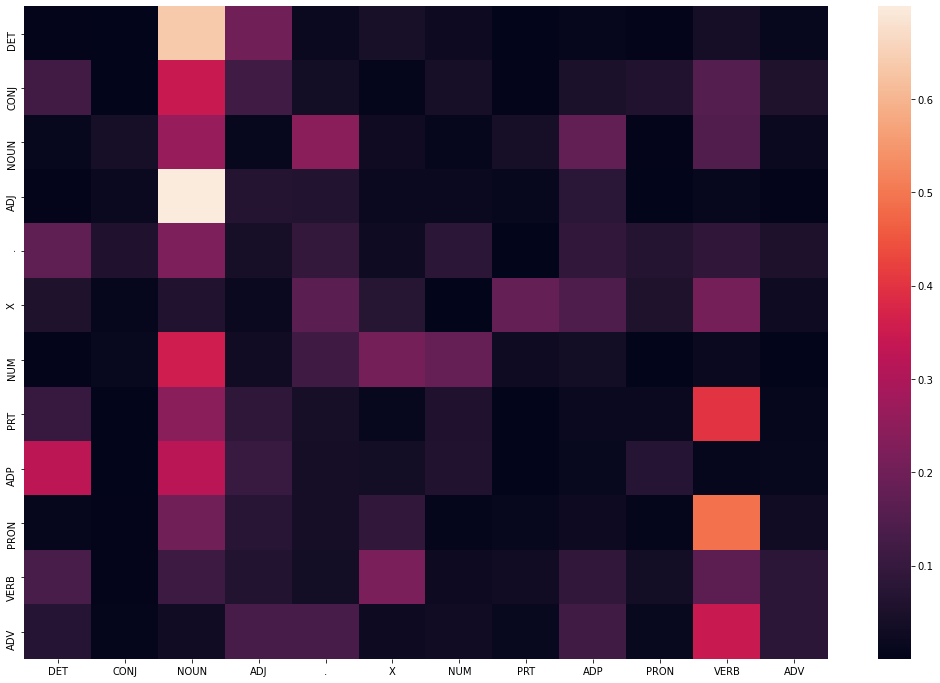

In [19]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

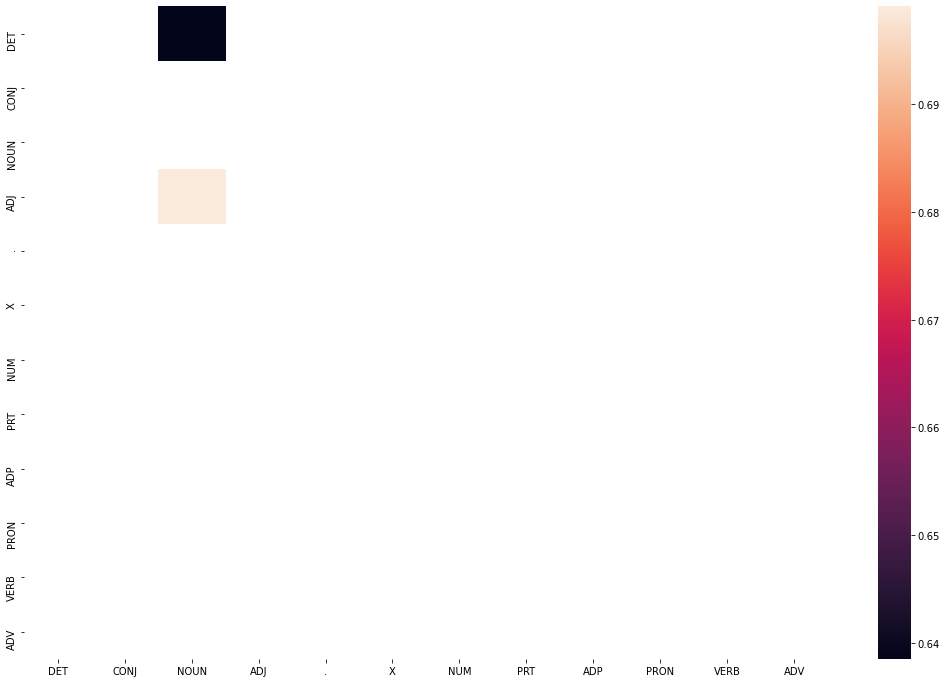

In [20]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [21]:
len(train_tagged_words)

95574

In [22]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

### Tagging the validation data

In [23]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(20)]
print('\nrndom: ',rndom[:20])

# list of sents
test_run = [test_set[i] for i in rndom]
print('\ntest_run: ',test_run[:20])
print('\nLength of test_run: ',len(test_run))  



rndom:  [113, 30, 2, 24, 150, 9, 172, 178, 22, 26, 91, 61, 5, 8, 5, 89, 166, 160, 124, 158]

test_run:  [[('Like', 'ADP'), ('most', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('other', 'ADJ'), ('6,000', 'NUM'), ('churches', 'NOUN'), ('in', 'ADP'), ('Britain', 'NOUN'), ('with', 'ADP'), ('sets', 'NOUN'), ('of', 'ADP'), ('bells', 'NOUN'), (',', '.'), ('St.', 'NOUN'), ('Michael', 'NOUN'), ('once', 'ADV'), ('had', 'VERB'), ('its', 'PRON'), ('own', 'ADJ'), ('``', '.'), ('band', 'NOUN'), ("''", '.'), ('of', 'ADP'), ('ringers', 'NOUN'), (',', '.'), ('who', 'PRON'), ('*T*-221', 'X'), ('would', 'VERB'), ('herald', 'VERB'), ('every', 'DET'), ('Sunday', 'NOUN'), ('morning', 'NOUN'), ('and', 'CONJ'), ('evening', 'NOUN'), ('service', 'NOUN'), ('.', '.')], [('--', '.'), ('In', 'ADP'), ('Britain', 'NOUN'), (',', '.'), ('the', 'DET'), ('benchmark', 'NOUN'), ('11', 'NUM'), ('3\\/4', 'NUM'), ('%', 'NOUN'), ('bond', 'NOUN'), ('due', 'ADJ'), ('2003\\/2007', 'NUM'), ('fell', 'VERB'), ('14\\/32', 'NUM'), ('to',

In [24]:
# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]
print('\ntest_run_base: ',test_run_base[:10])
print('\nLength of test_run_base: ',len(test_run_base))
    
# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
print('\ntest_tagged_words: ',test_tagged_words[:10])
print('\nLength of test_tagged_words: ',len(test_tagged_words))

start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()

difference = end-start

print("\nTime taken in seconds: ", difference)
print('\ntagged_seq: ',tagged_seq[:10])
print('\nLength of tagged_seq: ',len(tagged_seq))

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy = len(check)/len(tagged_seq)


test_run_base:  [('Like', 'ADP'), ('most', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('other', 'ADJ'), ('6,000', 'NUM'), ('churches', 'NOUN'), ('in', 'ADP'), ('Britain', 'NOUN'), ('with', 'ADP')]

Length of test_run_base:  500

test_tagged_words:  ['Like', 'most', 'of', 'the', 'other', '6,000', 'churches', 'in', 'Britain', 'with']

Length of test_tagged_words:  500

Time taken in seconds:  90.97492027282715

tagged_seq:  [('Like', 'ADP'), ('most', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('other', 'ADJ'), ('6,000', 'NUM'), ('churches', 'NOUN'), ('in', 'ADP'), ('Britain', 'NOUN'), ('with', 'ADP')]

Length of tagged_seq:  500


### Tag validation data - 5% data

In [25]:
print('\nViterbi Algorithm Accuracy on 5% validation data: ',accuracy*100)


Viterbi Algorithm Accuracy on 5% validation data:  90.60000000000001


#### Let's check the incorrectly tagged words

In [26]:
incorrect_tagged_cases = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [27]:
incorrect_tagged_cases

[(('*T*-221', 'DET'), ('*T*-221', 'X')),
 (('herald', 'DET'), ('herald', 'VERB')),
 (('2003\\/2007', 'DET'), ('2003\\/2007', 'NUM')),
 (('14\\/32', 'DET'), ('14\\/32', 'NUM')),
 (('10.19', 'DET'), ('10.19', 'NUM')),
 (('help', 'VERB'), ('help', 'NOUN')),
 (('needed', 'VERB'), ('needed', 'ADJ')),
 (('net', 'ADJ'), ('net', 'NOUN')),
 (('734.9', 'DET'), ('734.9', 'NUM')),
 (('down', 'ADV'), ('down', 'ADP')),
 (('811.9', 'DET'), ('811.9', 'NUM')),
 (('3.04', 'DET'), ('3.04', 'NUM')),
 (('that', 'DET'), ('that', 'ADP')),
 (('replicated', 'DET'), ('replicated', 'VERB')),
 (('participant', 'DET'), ('participant', 'NOUN')),
 (('knife', 'DET'), ('knife', 'NOUN')),
 (('forecast', 'VERB'), ('forecast', 'NOUN')),
 (('most', 'ADJ'), ('most', 'ADV')),
 (('devastating', 'VERB'), ('devastating', 'ADJ')),
 (('high', 'ADJ'), ('high', 'NOUN')),
 (('twice', 'DET'), ('twice', 'ADV')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('till', 'DET'), ('till', 'ADP')),
 (('issuer', 'DET'), ('issuer', 'NOUN')),
 (('bust', 

In [28]:
print("Total Incorrect Tagged Words :", len(incorrect_tagged_cases))

Total Incorrect Tagged Words : 47


#### Unknown words
#### The unknown words have been tagged as 'NUM' as 'NUM' is the first tag in tag list and is assigned if unknown word is encountered (emission probability =0).

### Viterbi Modification-Technique I

#### Assign max probabilities based on occurence to target unknown words 

#### Adding Tag occurance probability weights: we will apply weights based on the probability of tag occurance to the transition probabilities of tags and then use the resulting probability for predicting unknown words.

In [29]:
tags = set([pair[1] for pair in train_tagged_words])
len(tags)

12

In [30]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
print('Probability based tagger')
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
tags = set([pair[1] for pair in train_tagged_words])
for t in tags:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

Probability based tagger


[('DET', 0.08697972251867662),
 ('CONJ', 0.02254797329817733),
 ('NOUN', 0.28683533178479503),
 ('ADJ', 0.06366794316445895),
 ('.', 0.11634963483792664),
 ('X', 0.06547805888630799),
 ('NUM', 0.035302488124385294),
 ('PRT', 0.031755498357293827),
 ('ADP', 0.09782995375311278),
 ('PRON', 0.027214514407684097),
 ('VERB', 0.13463912779626258),
 ('ADV', 0.03139975307091887)]

In [31]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Viterbi_Max_Prob(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

#### Test accuracy on validation data 

In [32]:
print('Test untagged words ',test_tagged_words[:10])
print('\nLength untagged words ',len(test_tagged_words))

start = time.time()
tagged_seq = Viterbi_Max_Prob(test_tagged_words)
end = time.time()

print('\nTagged Sequence: ',tagged_seq[:20])
print('\n Length of tagged sequence: ',len(tagged_seq))

difference = end-start
 
print("\nTime taken by modified rule based Viterbi tagger in seconds: ", difference)
 

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
print('\nLength of check array: ',len(check))

Test untagged words  ['Like', 'most', 'of', 'the', 'other', '6,000', 'churches', 'in', 'Britain', 'with']

Length untagged words  500

Tagged Sequence:  [('Like', 'ADP'), ('most', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('other', 'ADJ'), ('6,000', 'NUM'), ('churches', 'NOUN'), ('in', 'ADP'), ('Britain', 'NOUN'), ('with', 'ADP'), ('sets', 'NOUN'), ('of', 'ADP'), ('bells', 'NOUN'), (',', '.'), ('St.', 'NOUN'), ('Michael', 'NOUN'), ('once', 'ADV'), ('had', 'VERB'), ('its', 'PRON'), ('own', 'ADJ')]

 Length of tagged sequence:  500

Time taken by modified rule based Viterbi tagger in seconds:  90.94329261779785

Length of check array:  463


In [33]:
# accuracy
accuracy_rule_based = len(check)/len(tagged_seq)

print('\nModification Technique 1 - Max transition probability - Viterbi Algorithm Accuracy: ',accuracy_rule_based*100)


Modification Technique 1 - Max transition probability - Viterbi Algorithm Accuracy:  92.60000000000001


#### Accuracy has improved from 88% to 92% as shown above

In [34]:
incorrect_tagged_cases = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [35]:
incorrect_tagged_cases

[(('*T*-221', 'VERB'), ('*T*-221', 'X')),
 (('herald', 'NOUN'), ('herald', 'VERB')),
 (('2003\\/2007', 'NOUN'), ('2003\\/2007', 'NUM')),
 (('14\\/32', 'NOUN'), ('14\\/32', 'NUM')),
 (('10.19', 'NOUN'), ('10.19', 'NUM')),
 (('help', 'VERB'), ('help', 'NOUN')),
 (('needed', 'VERB'), ('needed', 'ADJ')),
 (('net', 'ADJ'), ('net', 'NOUN')),
 (('734.9', 'NOUN'), ('734.9', 'NUM')),
 (('down', 'ADV'), ('down', 'ADP')),
 (('811.9', 'NOUN'), ('811.9', 'NUM')),
 (('3.04', 'NOUN'), ('3.04', 'NUM')),
 (('that', 'DET'), ('that', 'ADP')),
 (('forecast', 'VERB'), ('forecast', 'NOUN')),
 (('most', 'ADJ'), ('most', 'ADV')),
 (('devastating', 'VERB'), ('devastating', 'ADJ')),
 (('high', 'ADJ'), ('high', 'NOUN')),
 (('twice', 'NOUN'), ('twice', 'ADV')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('till', 'NOUN'), ('till', 'ADP')),
 (('restructures', 'NOUN'), ('restructures', 'VERB')),
 (('all', 'DET'), ('all', 'ADV')),
 (('right', 'NOUN'), ('right', 'ADV')),
 (('twice', 'NOUN'), ('twice', 'ADV')),
 (('as', 'ADP')

#### No of incorrectly tagged words have significantly reduced from 51 to 35

In [36]:
print("Total Incorrect Tagged Words :", len(incorrect_tagged_cases))

Total Incorrect Tagged Words : 37


### Viterbi Modification-Technique II

### Lexicon Tagger

#### Unigram Tagger

In [37]:
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", accuracy_unigram_tagger*100)

The accuracy of the Unigram Tagger is - 90.98392787142298


#### Bigram Tagger

In [38]:
bigram_tagger = nltk.BigramTagger(train_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger is -", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger is - 0.1826734613876911


#### Unigram's accuracy is better, so we will go with Unigram from Lexicon based.

In [39]:
# specify patterns for tagging
patterns = [    
    (r'.*ing$', 'VERB'),              # verb
    (r'^([A-Z]+)$','NOUN'),            # All capital letters NOUN 
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb   
    (r'.*ous$', 'ADJ'),               # adjective
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]
 
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

#### Modified Viterbi to include Lexicon and Rule based tagger in it

In [40]:
# building the train vocabulary to a set
training_vocabulary_set = set(tokens)

In [41]:
# A unigram tagger backed off by a rule based tagger.

def unigram_tagger(word, train_set = train_set):    
    
    # trigram backed up by the regex tagger
    unigram_regex_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)
    return unigram_regex_tagger.tag_sents([[(word)]])

In [42]:
# viterbi with handling for unknown words from regex tagger

def Viterbi_Unigram_Tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):        
        if word not in training_vocabulary_set:
            # for unknown words use unigram tagger backed by rule based
            unk_word_tag=unigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [43]:
print('Lexicon Rule based tagger')
print('Test untagged words ',test_tagged_words[:10])
print('\nLength untagged words ',len(test_tagged_words))

start = time.time()
tagged_seq = Viterbi_Unigram_Tagger(test_tagged_words)
end = time.time()

print('\nTagged Sequence: ',tagged_seq[:20])
print('\nLength of tagged sequence: ',len(tagged_seq))

difference = end-start
 
print("\nTime taken by modified rule based Viterbi tagger in seconds: ", difference)
 
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
print('\nLength of check array: ',len(check))

Lexicon Rule based tagger
Test untagged words  ['Like', 'most', 'of', 'the', 'other', '6,000', 'churches', 'in', 'Britain', 'with']

Length untagged words  500

Tagged Sequence:  [('Like', 'ADP'), ('most', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('other', 'ADJ'), ('6,000', 'NUM'), ('churches', 'NOUN'), ('in', 'ADP'), ('Britain', 'NOUN'), ('with', 'ADP'), ('sets', 'NOUN'), ('of', 'ADP'), ('bells', 'NOUN'), (',', '.'), ('St.', 'NOUN'), ('Michael', 'NOUN'), ('once', 'ADV'), ('had', 'VERB'), ('its', 'PRON'), ('own', 'ADJ')]

Length of tagged sequence:  500

Time taken by modified rule based Viterbi tagger in seconds:  119.36264657974243

Length of check array:  474


In [44]:
# accuracy
accuracy_lexicon_rule_based = len(check)/len(tagged_seq)

print('\nModification Technique 2 - Lexicon backed by Rule based - Viterbi Algorithm Accuracy: ',accuracy_lexicon_rule_based*100)


Modification Technique 2 - Lexicon backed by Rule based - Viterbi Algorithm Accuracy:  94.8


#### Accuracy has improved from 92 to 93% as shown above

In [45]:
incorrect_tagged_cases = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [46]:
incorrect_tagged_cases

[(('*T*-221', 'NOUN'), ('*T*-221', 'X')),
 (('herald', 'NOUN'), ('herald', 'VERB')),
 (('2003\\/2007', 'NOUN'), ('2003\\/2007', 'NUM')),
 (('14\\/32', 'NOUN'), ('14\\/32', 'NUM')),
 (('help', 'VERB'), ('help', 'NOUN')),
 (('needed', 'VERB'), ('needed', 'ADJ')),
 (('net', 'ADJ'), ('net', 'NOUN')),
 (('down', 'ADV'), ('down', 'ADP')),
 (('that', 'DET'), ('that', 'ADP')),
 (('forecast', 'VERB'), ('forecast', 'NOUN')),
 (('most', 'ADJ'), ('most', 'ADV')),
 (('devastating', 'VERB'), ('devastating', 'ADJ')),
 (('high', 'ADJ'), ('high', 'NOUN')),
 (('twice', 'NOUN'), ('twice', 'ADV')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('till', 'NOUN'), ('till', 'ADP')),
 (('all', 'DET'), ('all', 'ADV')),
 (('right', 'NOUN'), ('right', 'ADV')),
 (('twice', 'NOUN'), ('twice', 'ADV')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('decade-long', 'NOUN'), ('decade-long', 'ADJ')),
 (('that', 'ADP'), ('that', 'DET')),
 (('bedding', 'VERB'), ('bedding', 'NOUN')),
 (('eight-count', 'NOUN'), ('eight-count', 'ADJ')),
 (('manip

In [47]:
print("Total Incorrect Tagged Words :", len(incorrect_tagged_cases))

Total Incorrect Tagged Words : 26


#### No of incorrectly tagged words have reduced from 35 to 32

### Evaluating tagging on sample 'Test_sentences.txt' file

### Test accuracy on validation data

In [48]:
f = open('Test_sentences.txt')
text = f.read()
f.close()
print('File read.')
print('\nLength of text file: ',len(text))

File read.

Length of text file:  993


In [49]:
sample_test_sent = text.splitlines()
print('sample_test_sent: ', sample_test_sent)
print('\nLength of sample_test_sent: ',len(sample_test_sent))

sample_test_sent:  ['Android is a mobile operating system developed by Google.', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.', 'Show me the cheapest round trips from Dallas to Atlanta', 'I would like to see flights from Denver to Philadelphia.', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.', 'NASA invited social media users to 

In [50]:
# list of untagged words
sample_test_words = [word for sent in sample_test_sent for word in sent.split()]
print('sample_test_words: ', sample_test_words[:10])
print('\nLength of sample_test_words: ',len(sample_test_words))

sample_test_words:  ['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google.', 'Android']

Length of sample_test_words:  168


### Test sample test data - 'Test_sentences.txt' with Viterbi

In [51]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print('\nTagged Sequence: ',sample_tagged_seq)
print('\n Length of tagged sequence: ',len(sample_tagged_seq))

Time taken in seconds:  33.82603311538696

Tagged Sequence:  [('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'DET'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'DET'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'DET'), ('firehose.', 'DET'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'),

### Technique1 - Test sample test data - 'Test_sentences.txt' with modified Viterbi

In [52]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi_Max_Prob(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print('\nTagged Sequence: ',sample_tagged_seq)
print('\n Length of tagged sequence: ',len(sample_tagged_seq))

Time taken in seconds:  33.9452109336853

Tagged Sequence:  [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'NOUN'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'NOUN'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'NOUN'), ('firehose.', 'NOUN'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('

### Technique2 - Test sample test data - 'Test_sentences.txt' with modified Viterbi

In [53]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi_Unigram_Tagger(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print('\nTagged Sequence: ',sample_tagged_seq)
print('\n Length of tagged sequence: ',len(sample_tagged_seq))

Time taken in seconds:  62.57760691642761

Tagged Sequence:  [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'NOUN'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'NOUN'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'NOUN'), ('firehose.', 'NOUN'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('w

#### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm
The accuracy of *vanilla Viterbi* Algorithm: **88%**

The accuracy of *Technique-I modified Viterbi using max probability* Algorithm: **92%**

The accuracy of *Technique-II modified Viterbi using Lexicon and Rule based* Algorithm: **93%**


*The following cases were incorrectly tagged by Viterbi, are now corrected by modified Viterbi Algorithm, however the time taken is double than that of original Viterbi*

- ('Android', 'NOUN')

- ('Google', 'PRON')

- ('operating', 'NOUN')

- ('2011', 'NUM')

- ('ICESAT-2', 'NOUN') 

- ('Satellite.', 'NOUN')